In [1]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import joblib
import os
from sklearn.feature_selection import f_classif, chi2, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  f1_score, recall_score, precision_score



file_path = "/Users/ML-EdgeIIoT-dataset.csv"
data = pd.read_csv(file_path, low_memory=False)

CPU times: user 2.92 s, sys: 2.87 s, total: 5.79 s
Wall time: 3.19 s


In [2]:
%%time
# Columns to drop from DataFrame is named 'df'
columns_to_drop = [
    'frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
    'arp.src.proto_ipv4', 'icmp.checksum', 'icmp.seq_le', 'icmp.transmit_timestamp',
    'icmp.unused', 'http.file_data', 'http.request.uri.query', 'http.request.method',
    'http.referer', 'http.request.full_uri', 'http.request.version', 'http.response',
    'tcp.checksum', 'tcp.options', 'tcp.payload', 'udp.stream', 'udp.time_delta',
    'dns.qry.name', 'dns.qry.name.len', 'dns.retransmission', 'dns.retransmit_request',
    'dns.retransmit_request_in', 'mqtt.conack.flags', 'mqtt.msg_decoded_as', 'mqtt.msg',
    'mqtt.protoname', 'mqtt.topic', 'mbtcp.trans_id', 'mbtcp.unit_id'
]

# Drop the specified columns
df = data.drop(columns=columns_to_drop)

# Print the updated DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157800 entries, 0 to 157799
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   arp.opcode              157800 non-null  float64
 1   arp.hw.size             157800 non-null  float64
 2   http.content_length     157800 non-null  float64
 3   http.tls_port           157800 non-null  float64
 4   tcp.ack                 157800 non-null  float64
 5   tcp.ack_raw             157800 non-null  float64
 6   tcp.connection.fin      157800 non-null  float64
 7   tcp.connection.rst      157800 non-null  float64
 8   tcp.connection.syn      157800 non-null  float64
 9   tcp.connection.synack   157800 non-null  float64
 10  tcp.dstport             157800 non-null  float64
 11  tcp.flags               157800 non-null  float64
 12  tcp.flags.ack           157800 non-null  float64
 13  tcp.len                 157800 non-null  float64
 14  tcp.seq             

In [3]:
%%time
label_counts = df['Attack_type'].value_counts() #Total number of outut and frequencies 
print(label_counts)

Attack_type
Normal                   24301
DDoS_UDP                 14498
DDoS_ICMP                14090
Ransomware               10925
DDoS_HTTP                10561
SQL_injection            10311
Uploading                10269
DDoS_TCP                 10247
Backdoor                 10195
Vulnerability_scanner    10076
Port_Scanning            10071
XSS                      10052
Password                  9989
MITM                      1214
Fingerprinting            1001
Name: count, dtype: int64
CPU times: user 4.68 ms, sys: 238 µs, total: 4.92 ms
Wall time: 5.23 ms


In [4]:
%%time

# Define a regular expression pattern to match the entries to be eliminated
pattern = r'DESKTOP-UHF0SF2|DESKTOP-UHF0SF2\.local|_googlecast\._tcp\.local'

# Create a boolean mask indicating which rows have the specified entries in 'tcp.srcport'
mask = df['tcp.srcport'].str.contains(pattern, regex=True)

# Replace the specified entries with a default value (e.g., 0)
df.loc[mask, 'tcp.srcport'] = 0

# Convert the 'tcp.srcport' column to numeric data type
df['tcp.srcport'] = pd.to_numeric(df['tcp.srcport'], errors='coerce')

# Print the updated DataFrame
#print(df)

CPU times: user 59.6 ms, sys: 3.35 ms, total: 62.9 ms
Wall time: 71.3 ms


In [5]:
%%time
# Data features
X = df.drop(['Attack_label', 'Attack_type'], axis=1) 

# Target Variable
y = df['Attack_type'] # for multi-class classification (types of attacks).

#X.info()

CPU times: user 4.28 ms, sys: 4.24 ms, total: 8.52 ms
Wall time: 8.02 ms


In [6]:
%%time

# Convert X to a DataFrame
#X = pd.DataFrame(X)

# Store the feature names
feature_names = X.columns

# Remove constant features
constant_filter = VarianceThreshold(threshold=0)
X = constant_filter.fit_transform(X)

# Perform ANOVA F-test
with np.errstate(divide='ignore', invalid='ignore'):
    f_scores, p_values = f_classif(X, y)

# Create a DataFrame to store the ANOVA F-test results
anova_results = pd.DataFrame({'Feature': feature_names[constant_filter.get_support()], 'F-score': f_scores, 'p-value': p_values})

# Sort the results by F-score in descending order
anova_results = anova_results.sort_values('F-score', ascending=False)

print("ANOVA F-test results:")
print(anova_results)

# Perform Chi-Squared test
chi2_scores, p_values = chi2(X, y)

# Create a DataFrame to store the Chi-Squared test results
chi2_results = pd.DataFrame({'Feature': feature_names[constant_filter.get_support()], 'Chi2-score': chi2_scores, 'p-value': p_values})

# Sort the results by Chi2-score in descending order
chi2_results = chi2_results.sort_values('Chi2-score', ascending=False)

print("\nChi-Squared test results:")
print(chi2_results)

ANOVA F-test results:
                   Feature       F-score       p-value
10               tcp.flags  13121.586588  0.000000e+00
11           tcp.flags.ack  12038.253912  0.000000e+00
3                  tcp.ack   6334.830157  0.000000e+00
4              tcp.ack_raw   5376.709017  0.000000e+00
7       tcp.connection.syn   3717.469027  0.000000e+00
6       tcp.connection.rst   3253.471612  0.000000e+00
9              tcp.dstport   3117.015249  0.000000e+00
14             tcp.srcport   2200.444757  0.000000e+00
16              dns.qry.qu   1919.975688  0.000000e+00
12                 tcp.len   1358.312186  0.000000e+00
21            mqtt.msgtype   1053.240720  0.000000e+00
19           mqtt.hdrflags   1053.240720  0.000000e+00
5       tcp.connection.fin    979.716773  0.000000e+00
20                mqtt.len    904.167097  0.000000e+00
13                 tcp.seq    883.056044  0.000000e+00
1              arp.hw.size    572.120040  0.000000e+00
18           mqtt.conflags    517.045704  0

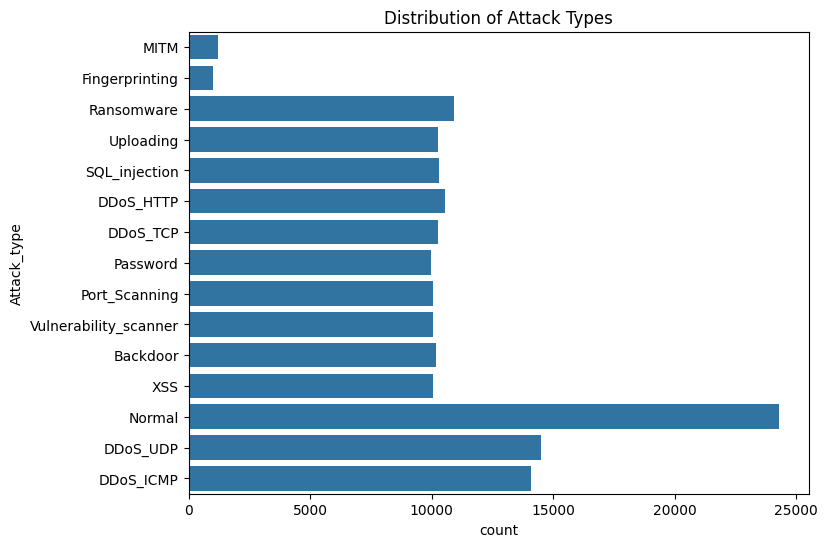

CPU times: user 706 ms, sys: 502 ms, total: 1.21 s
Wall time: 410 ms


In [7]:
%%time

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert the NumPy array back to a DataFrame
df = pd.DataFrame(X)

# Visualize distribution of target variable
plt.figure(figsize=(8,6))
sns.countplot(y=y)
plt.title("Distribution of Attack Types")
plt.show()


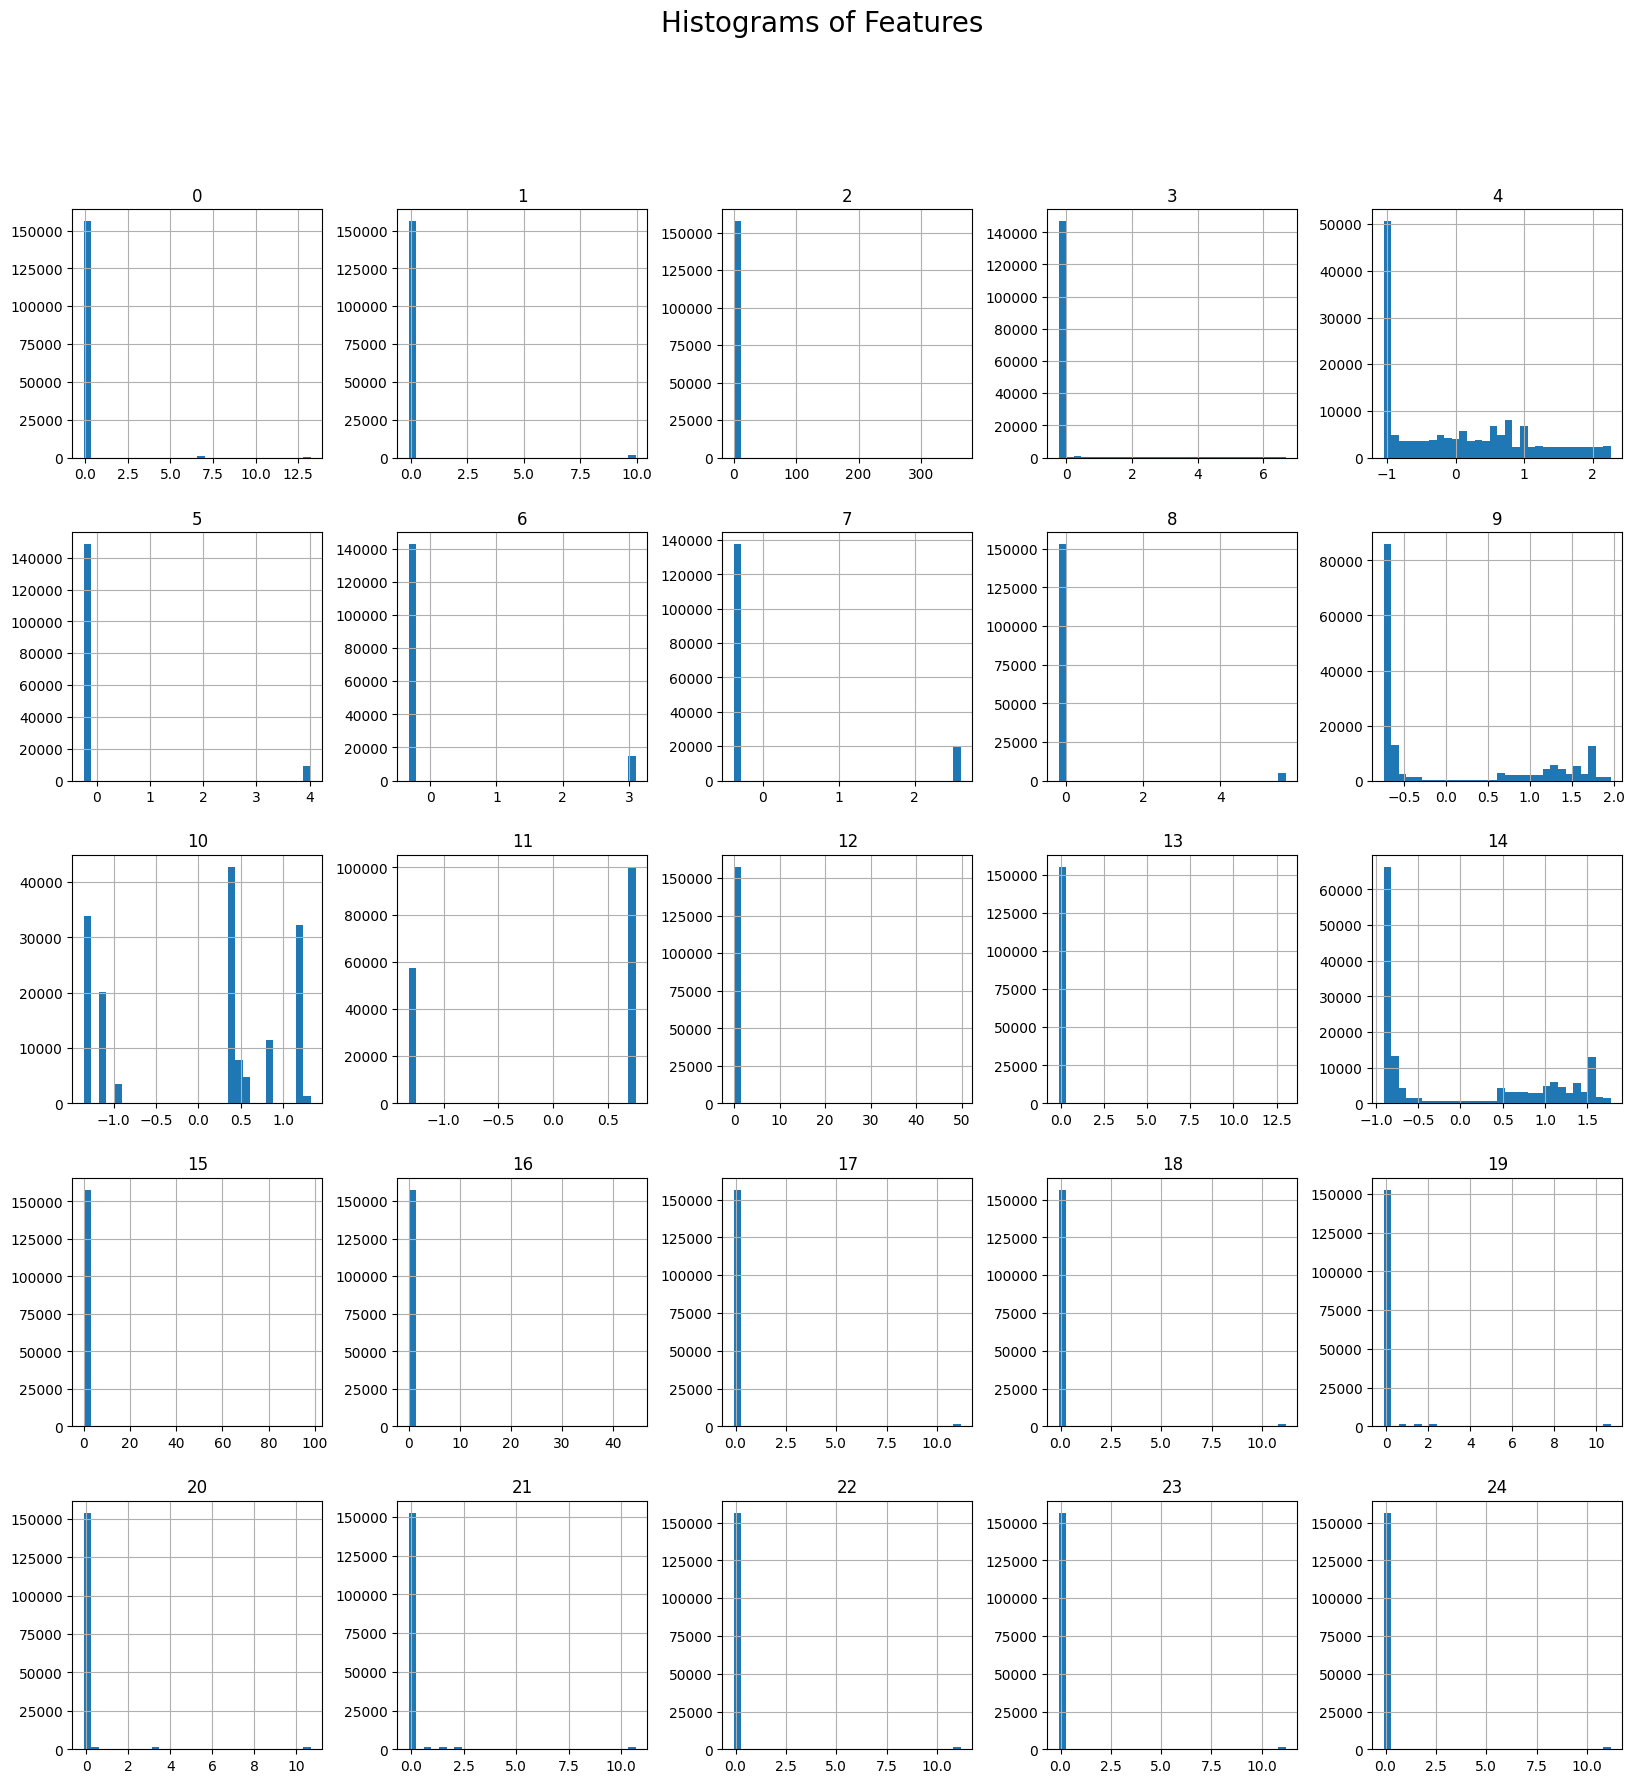

In [8]:
# Plot histograms of features
df.hist(bins=30, figsize=(20,20))
plt.suptitle("Histograms of Features", fontsize=20)
plt.show()

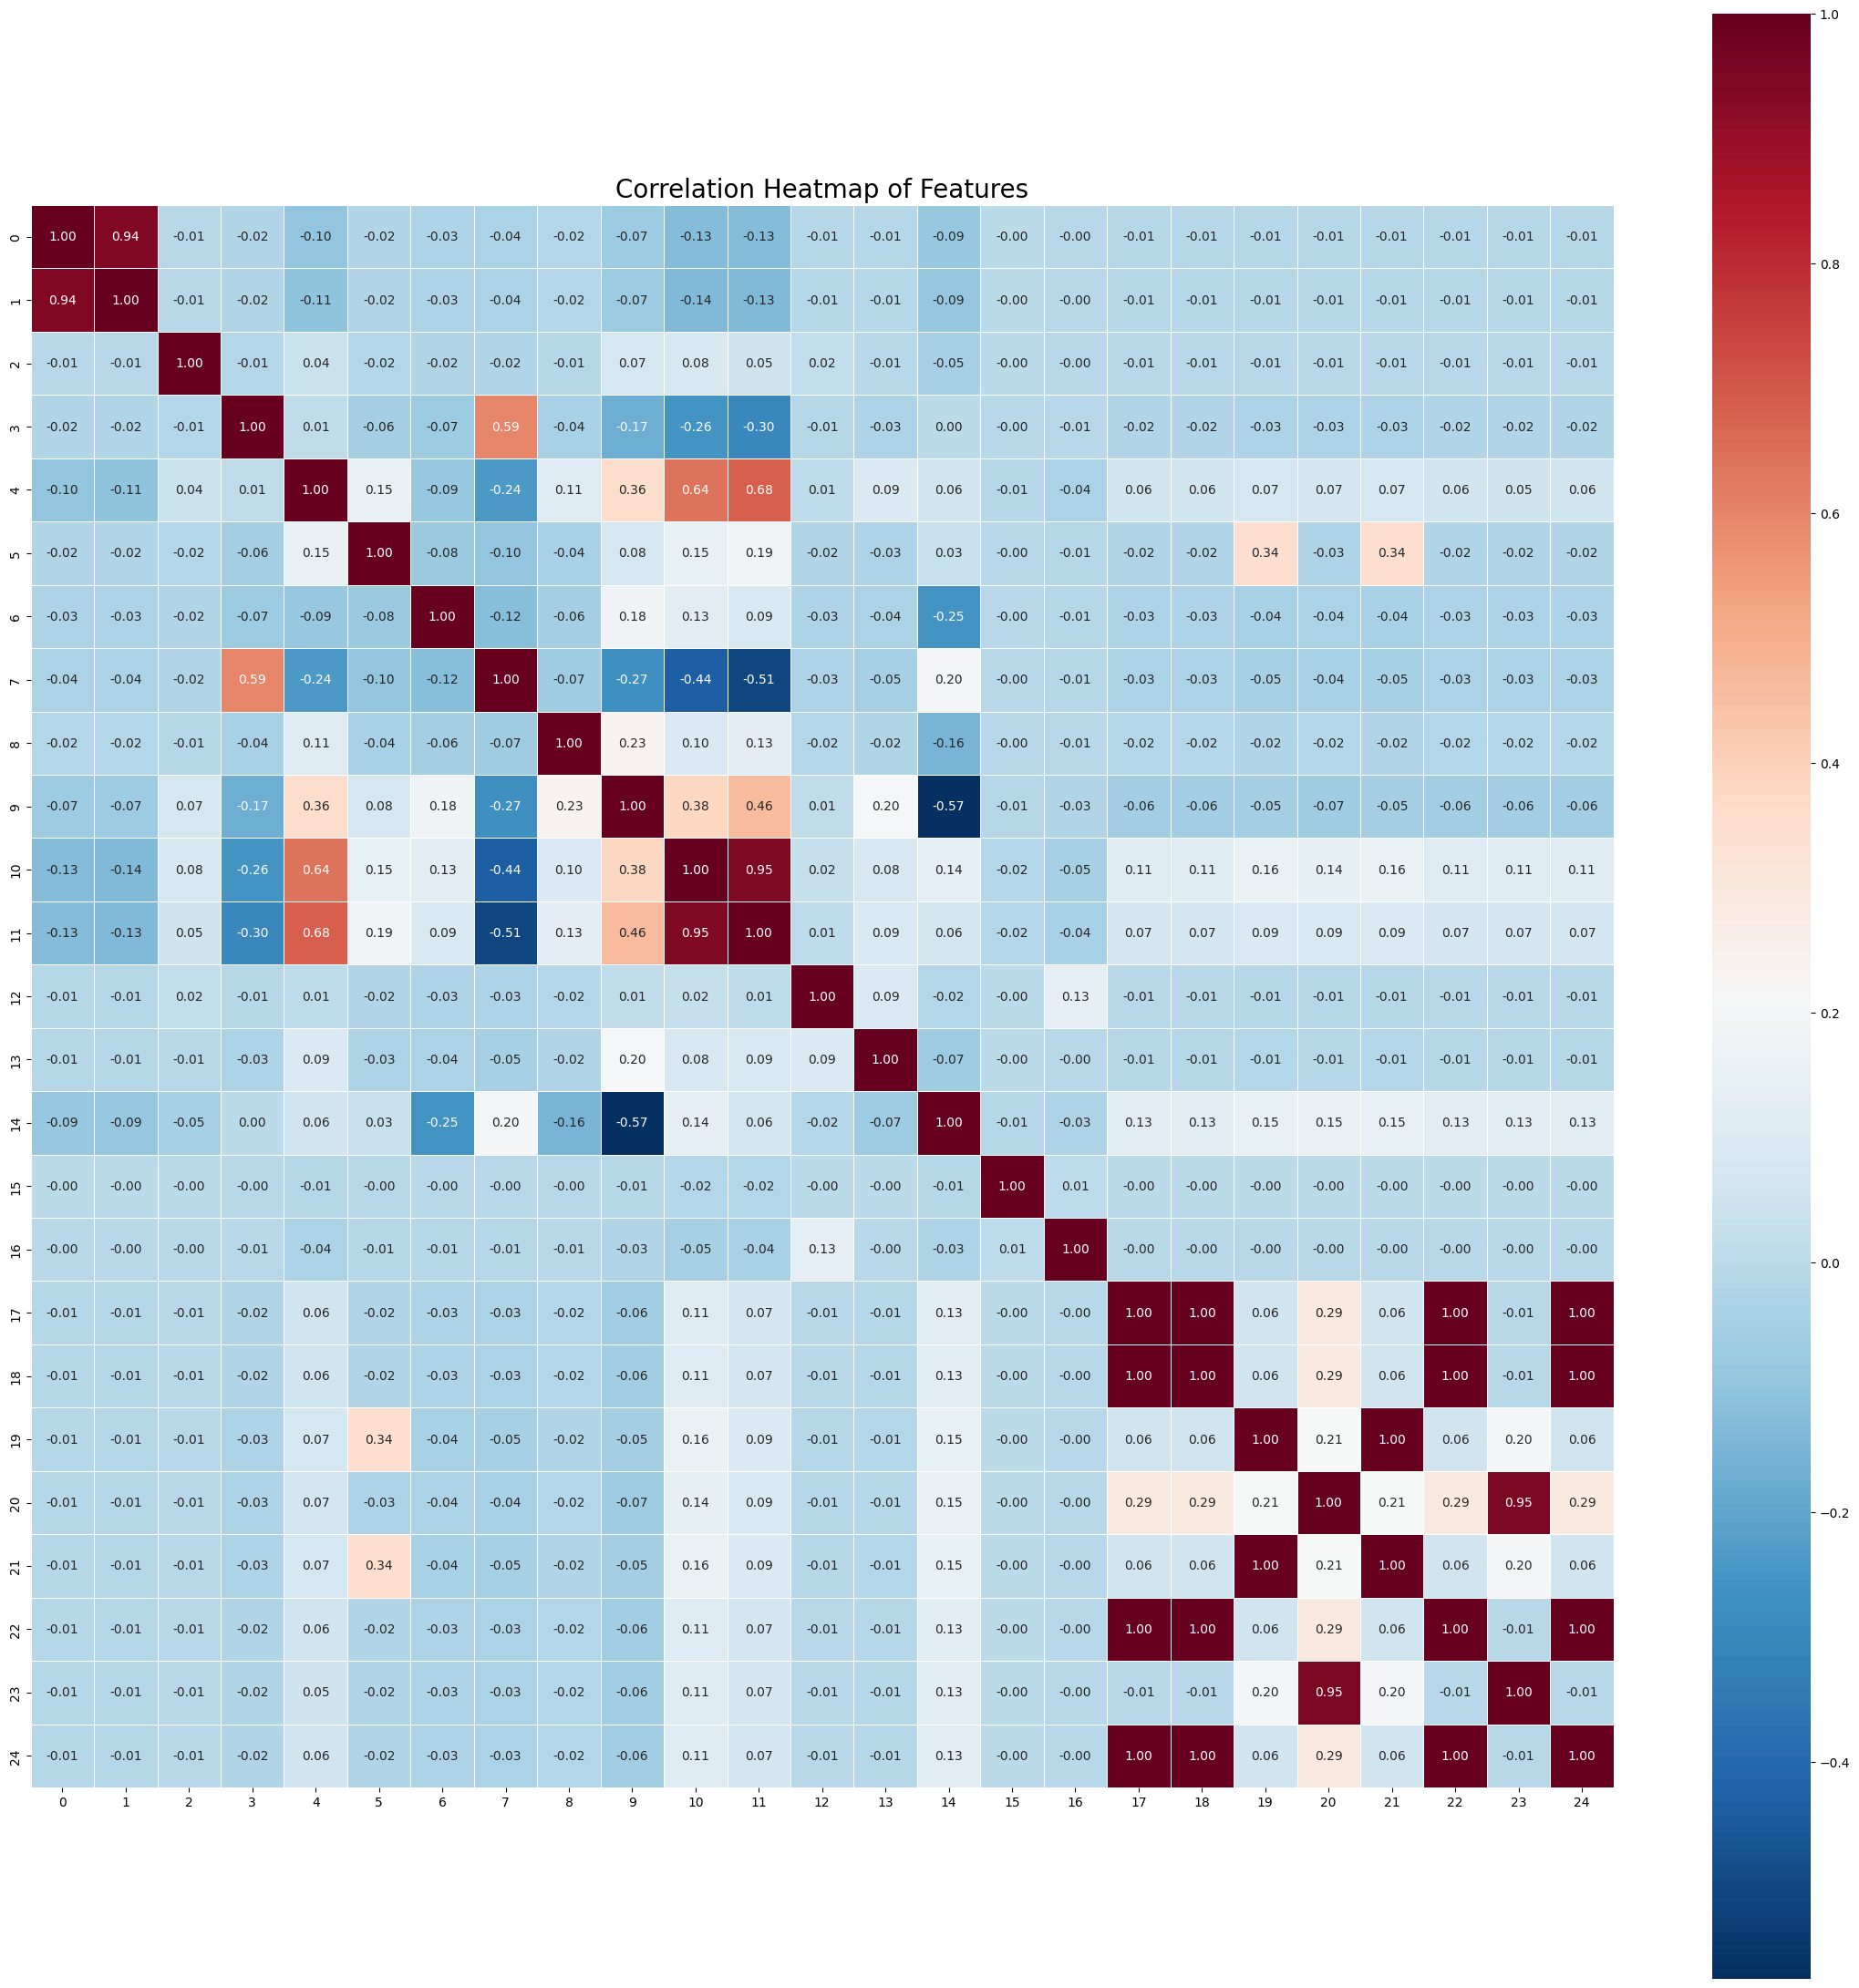

In [9]:
# Compute correlation matrix
corr = df.corr()

# Plot correlation heatmap
plt.figure(figsize=(28,28))
sns.heatmap(corr, cmap='RdBu_r', annot=True, fmt=".2f", annot_kws={'size':10}, 
            xticklabels=corr.columns, yticklabels=corr.columns, square=True, linewidth=0.5)
plt.title("Correlation Heatmap of Features", fontsize=20)
plt.show()

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
1,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
2,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
3,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
4,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157795,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
157796,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
157797,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
157798,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357


In [11]:
%%time
# Split the data into training+validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into training and validation sets
val_size = 0.2  # Validation set size (20% of the training+validation set)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

# Print the sizes of the testing, validation, and training sets
print(f"Testing set size: {len(X_test)}")
print(f"Validation set size: {len(X_val)}")
print(f"Training set size: {len(X_train)}")

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'

# Impute missing values in the training, validation, and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Check if the trained Random Forest model exists
if os.path.exists('rf_model.joblib'):
    # Load the trained model from disk
    rf = joblib.load('rf_model.joblib')
else:
    # Fit the Random Forest model on the imputed training data
    rf.fit(X_train_imputed, y_train)
    # Save the trained model to disk
    joblib.dump(rf, 'rf_model.joblib')

# Get feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get feature names
feature_names = df.columns

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select the top N features (e.g., top 18)
top_n_features = 18
selected_features = feature_importances_df.head(top_n_features)

# Filter the imputed training, validation, and testing data with selected features
X_train_selected = X_train_imputed[:, selected_features.index]
X_val_selected = X_val_imputed[:, selected_features.index]
X_test_selected = X_test_imputed[:, selected_features.index]

# Initialize a DataFrame to store the accuracies
accuracies_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])


# SVM
if os.path.exists('svm_model.joblib'):
    svm = joblib.load('svm_model.joblib')
else:
    svm = SVC()
    svm.fit(X_train_selected, y_train)
    joblib.dump(svm, 'svm_model.joblib')

svm_score_train = svm.score(X_train_selected, y_train)
svm_score_val = svm.score(X_val_selected, y_val)
svm_score_test = svm.score(X_test_selected, y_test)
accuracies_df = pd.concat([accuracies_df, pd.DataFrame({'Model': ['SVM'], 'Train Accuracy': [svm_score_train], 'Validation Accuracy': [svm_score_val], 'Test Accuracy': [svm_score_test]})], ignore_index=True)

# KNN
if os.path.exists('knn_model.joblib'):
    knn = joblib.load('knn_model.joblib')
else:
    knn = KNeighborsClassifier()
    knn.fit(X_train_selected, y_train)
    joblib.dump(knn, 'knn_model.joblib')

knn_score_train = knn.score(X_train_selected, y_train)
knn_score_val = knn.score(X_val_selected, y_val)
knn_score_test = knn.score(X_test_selected, y_test)
accuracies_df = pd.concat([accuracies_df, pd.DataFrame({'Model': ['KNN'], 'Train Accuracy': [knn_score_train], 'Validation Accuracy': [knn_score_val], 'Test Accuracy': [knn_score_test]})], ignore_index=True)

# MLP
if os.path.exists('mlp_model.joblib'):
    mlp = joblib.load('mlp_model.joblib')
else:
    mlp = MLPClassifier(max_iter=500)
    mlp.fit(X_train_selected, y_train)
    joblib.dump(mlp, 'mlp_model.joblib')

mlp_score_train = mlp.score(X_train_selected, y_train)
mlp_score_val = mlp.score(X_val_selected, y_val)
mlp_score_test = mlp.score(X_test_selected, y_test)
accuracies_df = pd.concat([accuracies_df, pd.DataFrame({'Model': ['MLP'], 'Train Accuracy': [mlp_score_train], 'Validation Accuracy': [mlp_score_val], 'Test Accuracy': [mlp_score_test]})], ignore_index=True)


# Print the accuracies table
from tabulate import tabulate
print(tabulate(accuracies_df, headers='keys', tablefmt='psql'))


Testing set size: 31560
Validation set size: 25248
Training set size: 100992


<timed exec>:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


+----+---------+------------------+-----------------------+-----------------+
|    | Model   |   Train Accuracy |   Validation Accuracy |   Test Accuracy |
|----+---------+------------------+-----------------------+-----------------|
|  0 | SVM     |         0.75304  |              0.752218 |        0.753169 |
|  1 | KNN     |         0.881268 |              0.843988 |        0.844835 |
|  2 | MLP     |         0.860167 |              0.857771 |        0.856305 |
+----+---------+------------------+-----------------------+-----------------+
CPU times: user 10min 56s, sys: 5.52 s, total: 11min 2s
Wall time: 9min 35s


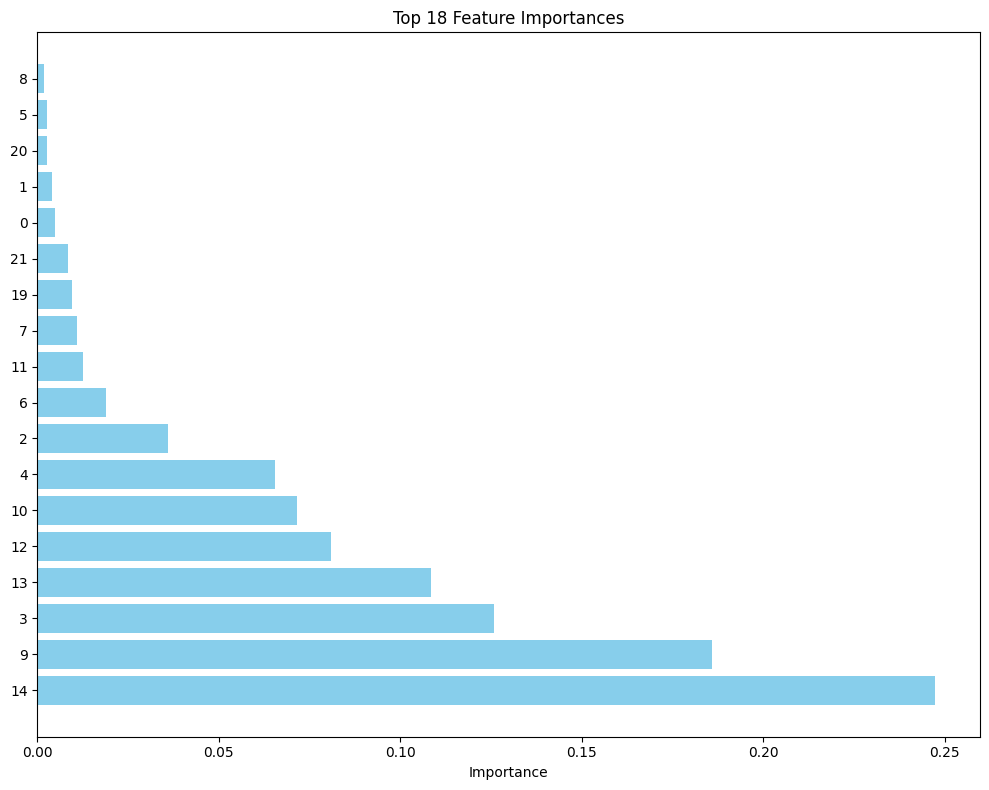

In [12]:
from tabulate import tabulate

# Visualize the top 18 feature importances
plt.figure(figsize=(10, 8))
plt.title("Top 18 Feature Importances")
plt.barh(range(len(selected_features)), selected_features['Importance'], color='skyblue', align='center')
plt.yticks(range(len(selected_features)), selected_features['Feature'])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



SVM - Training accuracy: 0.747
SVM - Validation accuracy: 0.747
SVM - Test accuracy: 0.749


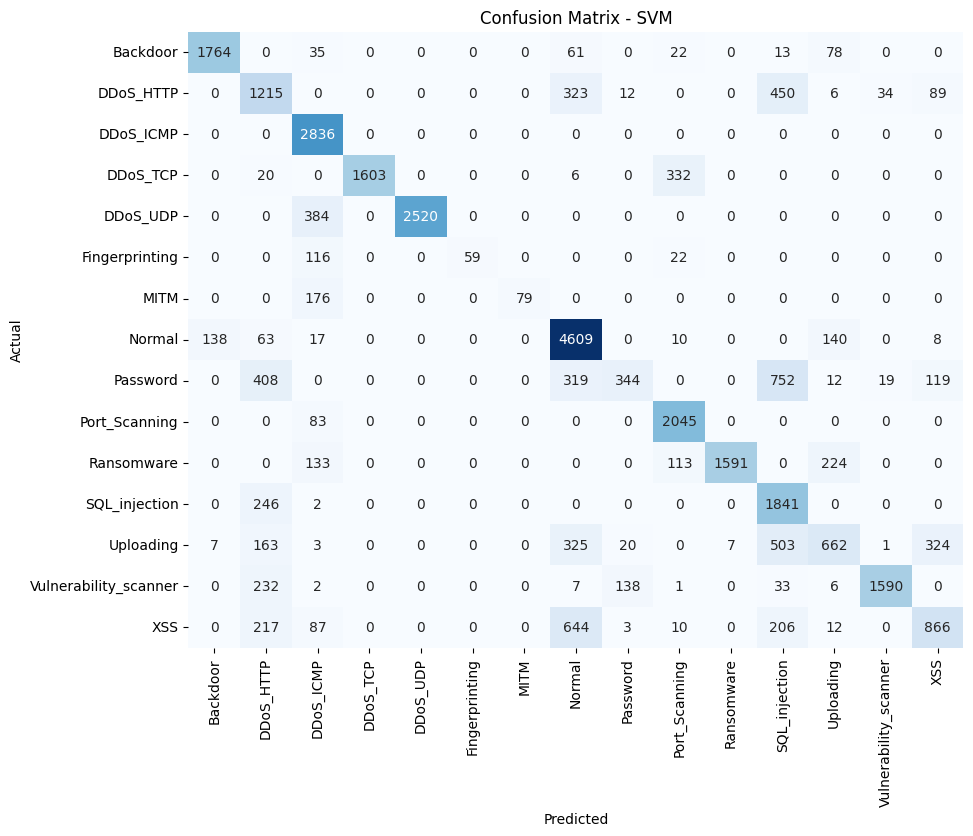

Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.92      0.89      0.91      1973
            DDoS_HTTP       0.47      0.57      0.52      2129
            DDoS_ICMP       0.73      1.00      0.85      2836
             DDoS_TCP       1.00      0.82      0.90      1961
             DDoS_UDP       1.00      0.87      0.93      2904
       Fingerprinting       1.00      0.30      0.46       197
                 MITM       1.00      0.31      0.47       255
               Normal       0.73      0.92      0.82      4985
             Password       0.67      0.17      0.28      1973
        Port_Scanning       0.80      0.96      0.87      2128
           Ransomware       1.00      0.77      0.87      2061
        SQL_injection       0.48      0.88      0.63      2089
            Uploading       0.58      0.33      0.42      2015
Vulnerability_scanner       0.97      0.79      0.87      2009
                  XSS       0.6

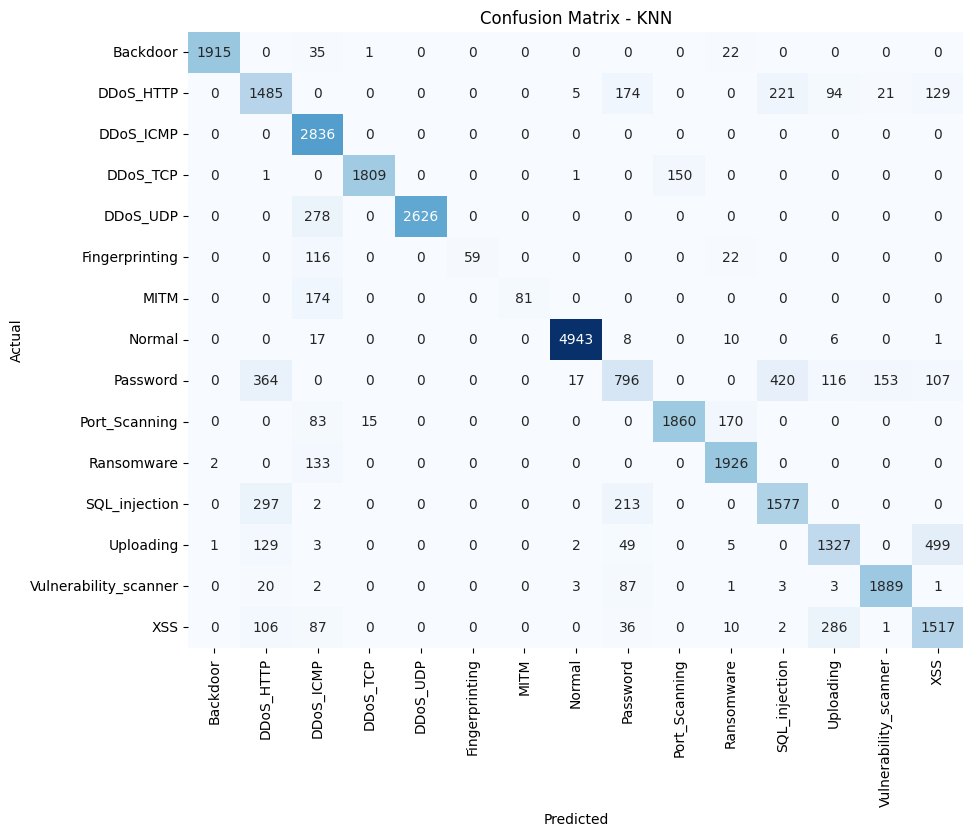

Classification Report:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.97      0.98      1973
            DDoS_HTTP       0.62      0.70      0.66      2129
            DDoS_ICMP       0.75      1.00      0.86      2836
             DDoS_TCP       0.99      0.92      0.96      1961
             DDoS_UDP       1.00      0.90      0.95      2904
       Fingerprinting       1.00      0.30      0.46       197
                 MITM       1.00      0.32      0.48       255
               Normal       0.99      0.99      0.99      4985
             Password       0.58      0.40      0.48      1973
        Port_Scanning       0.93      0.87      0.90      2128
           Ransomware       0.89      0.93      0.91      2061
        SQL_injection       0.71      0.75      0.73      2089
            Uploading       0.72      0.66      0.69      2015
Vulnerability_scanner       0.92      0.94      0.93      2009
                  XSS       0.6

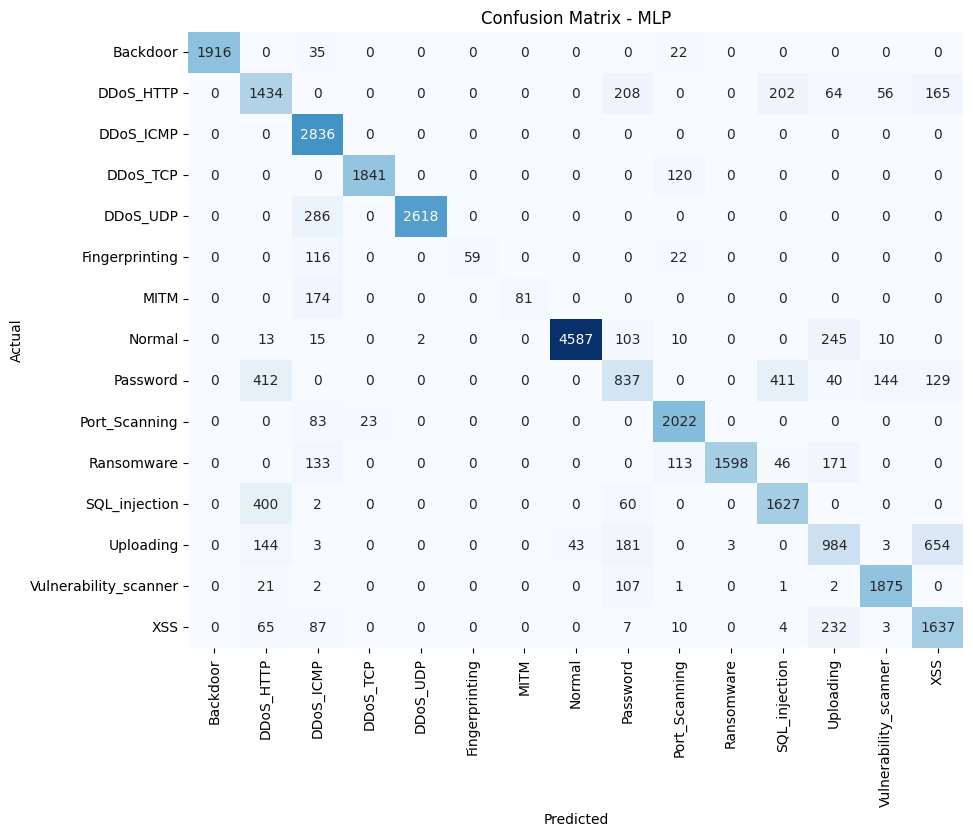

Classification Report:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.97      0.99      1973
            DDoS_HTTP       0.58      0.67      0.62      2129
            DDoS_ICMP       0.75      1.00      0.86      2836
             DDoS_TCP       0.99      0.94      0.96      1961
             DDoS_UDP       1.00      0.90      0.95      2904
       Fingerprinting       1.00      0.30      0.46       197
                 MITM       1.00      0.32      0.48       255
               Normal       0.99      0.92      0.95      4985
             Password       0.56      0.42      0.48      1973
        Port_Scanning       0.87      0.95      0.91      2128
           Ransomware       1.00      0.78      0.87      2061
        SQL_injection       0.71      0.78      0.74      2089
            Uploading       0.57      0.49      0.52      2015
Vulnerability_scanner       0.90      0.93      0.91      2009
                  XSS       0.6

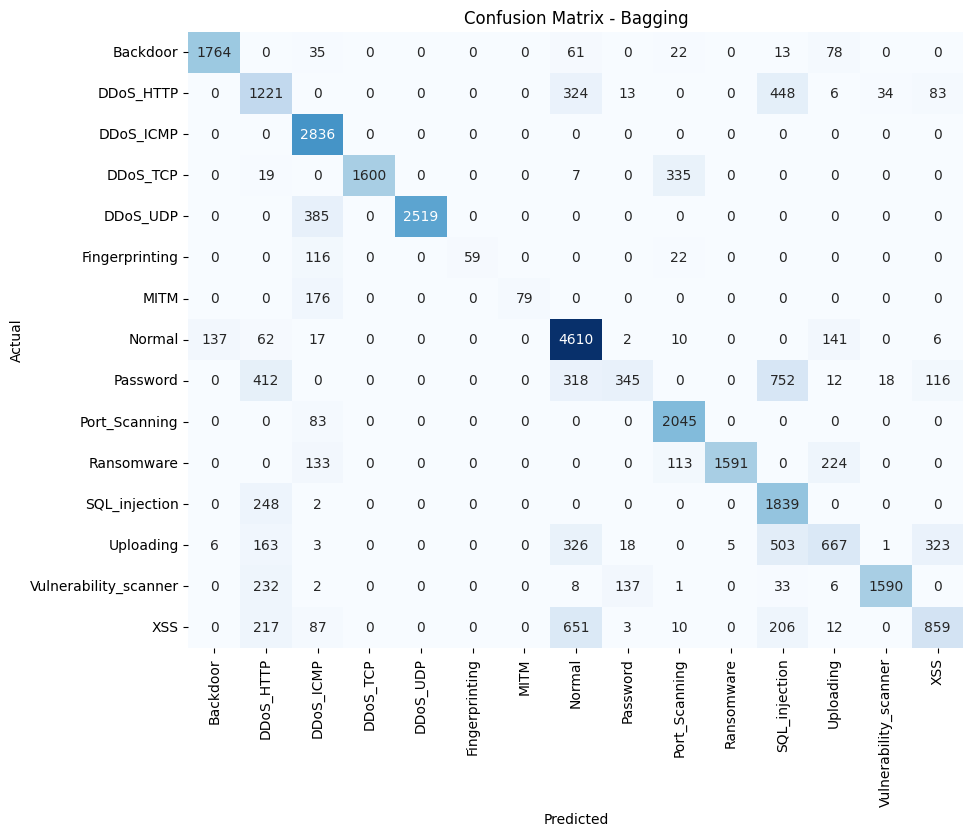

Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.93      0.89      0.91      1973
            DDoS_HTTP       0.47      0.57      0.52      2129
            DDoS_ICMP       0.73      1.00      0.85      2836
             DDoS_TCP       1.00      0.82      0.90      1961
             DDoS_UDP       1.00      0.87      0.93      2904
       Fingerprinting       1.00      0.30      0.46       197
                 MITM       1.00      0.31      0.47       255
               Normal       0.73      0.92      0.82      4985
             Password       0.67      0.17      0.28      1973
        Port_Scanning       0.80      0.96      0.87      2128
           Ransomware       1.00      0.77      0.87      2061
        SQL_injection       0.48      0.88      0.63      2089
            Uploading       0.58      0.33      0.42      2015
Vulnerability_scanner       0.97      0.79      0.87      2009
                  XSS       0.6

/Users/ebimol/miniforge3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Boosting - Training accuracy: 0.948
Boosting - Validation accuracy: 0.910
Boosting - Test accuracy: 0.909


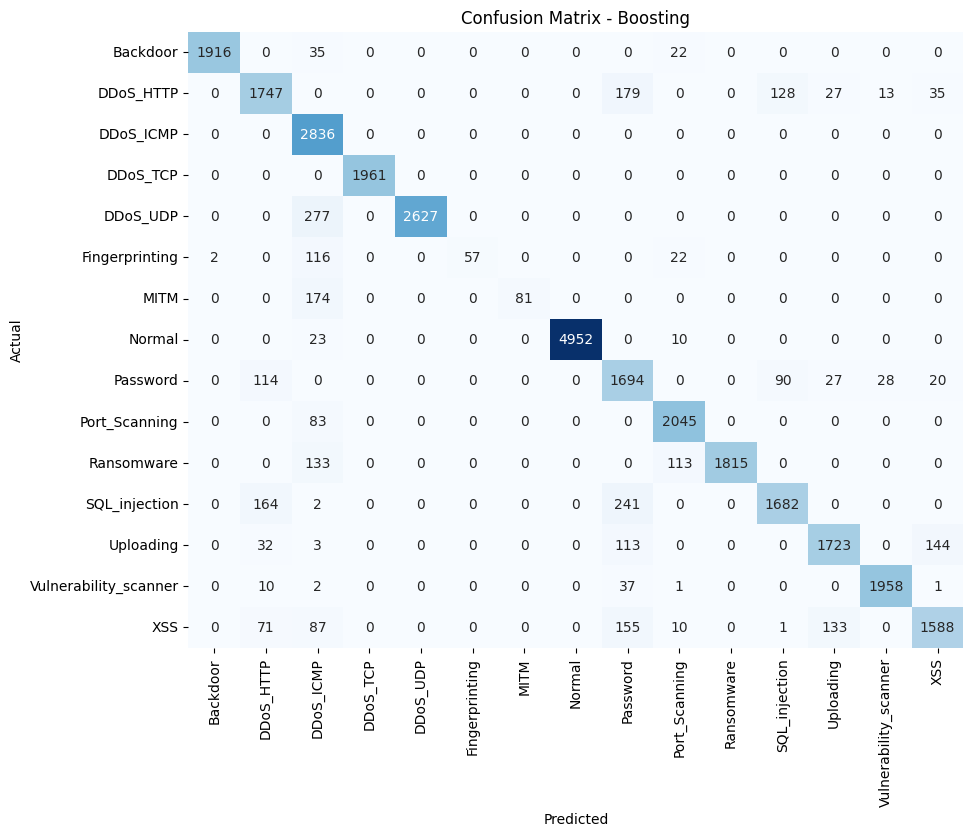

Classification Report:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.97      0.98      1973
            DDoS_HTTP       0.82      0.82      0.82      2129
            DDoS_ICMP       0.75      1.00      0.86      2836
             DDoS_TCP       1.00      1.00      1.00      1961
             DDoS_UDP       1.00      0.90      0.95      2904
       Fingerprinting       1.00      0.29      0.45       197
                 MITM       1.00      0.32      0.48       255
               Normal       1.00      0.99      1.00      4985
             Password       0.70      0.86      0.77      1973
        Port_Scanning       0.92      0.96      0.94      2128
           Ransomware       1.00      0.88      0.94      2061
        SQL_injection       0.88      0.81      0.84      2089
            Uploading       0.90      0.86      0.88      2015
Vulnerability_scanner       0.98      0.97      0.98      2009
                  XSS       0.8

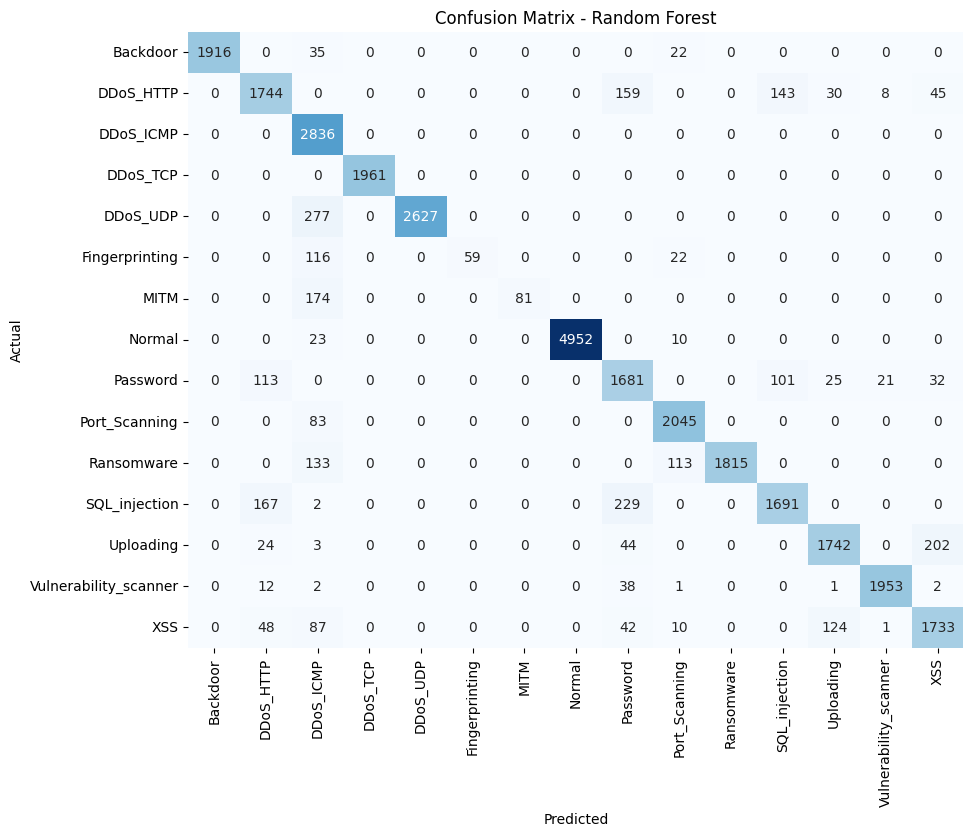

Classification Report:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.97      0.99      1973
            DDoS_HTTP       0.83      0.82      0.82      2129
            DDoS_ICMP       0.75      1.00      0.86      2836
             DDoS_TCP       1.00      1.00      1.00      1961
             DDoS_UDP       1.00      0.90      0.95      2904
       Fingerprinting       1.00      0.30      0.46       197
                 MITM       1.00      0.32      0.48       255
               Normal       1.00      0.99      1.00      4985
             Password       0.77      0.85      0.81      1973
        Port_Scanning       0.92      0.96      0.94      2128
           Ransomware       1.00      0.88      0.94      2061
        SQL_injection       0.87      0.81      0.84      2089
            Uploading       0.91      0.86      0.88      2015
Vulnerability_scanner       0.98      0.97      0.98      2009
                  XSS       0.8

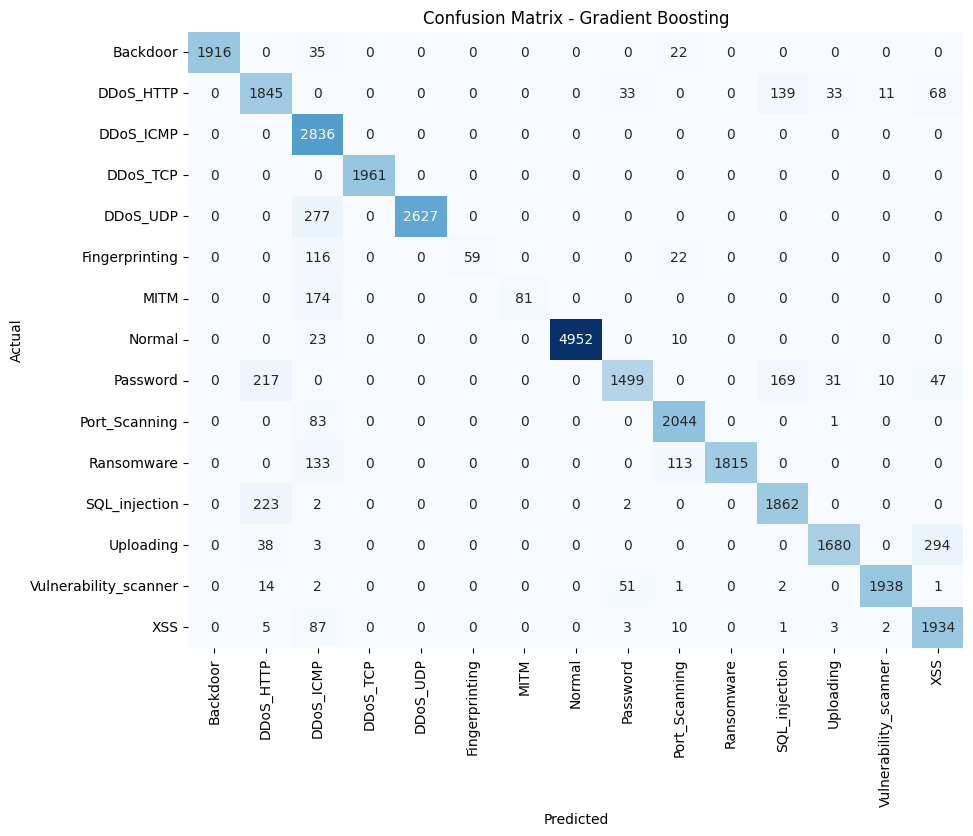

Classification Report:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.97      0.99      1973
            DDoS_HTTP       0.79      0.87      0.83      2129
            DDoS_ICMP       0.75      1.00      0.86      2836
             DDoS_TCP       1.00      1.00      1.00      1961
             DDoS_UDP       1.00      0.90      0.95      2904
       Fingerprinting       1.00      0.30      0.46       197
                 MITM       1.00      0.32      0.48       255
               Normal       1.00      0.99      1.00      4985
             Password       0.94      0.76      0.84      1973
        Port_Scanning       0.92      0.96      0.94      2128
           Ransomware       1.00      0.88      0.94      2061
        SQL_injection       0.86      0.89      0.87      2089
            Uploading       0.96      0.83      0.89      2015
Vulnerability_scanner       0.99      0.96      0.98      2009
                  XSS       0.8

/Users/ebimol/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking - Training accuracy: 0.863
Stacking - Validation accuracy: 0.850
Stacking - Test accuracy: 0.848


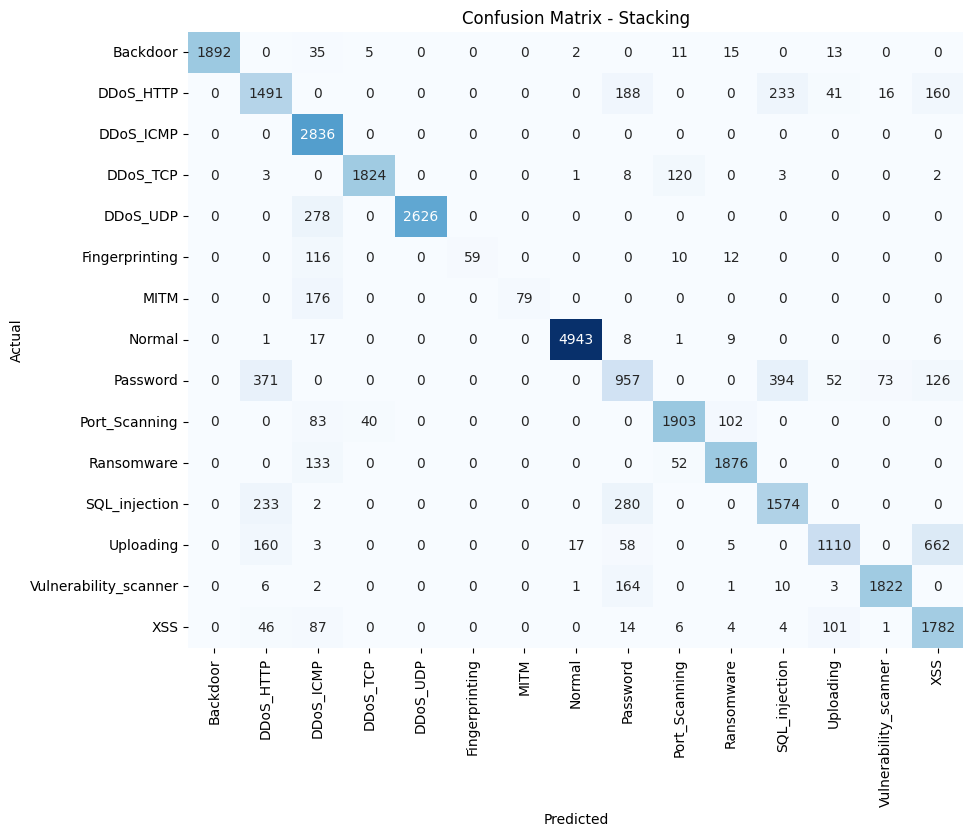

Classification Report:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.96      0.98      1973
            DDoS_HTTP       0.65      0.70      0.67      2129
            DDoS_ICMP       0.75      1.00      0.86      2836
             DDoS_TCP       0.98      0.93      0.95      1961
             DDoS_UDP       1.00      0.90      0.95      2904
       Fingerprinting       1.00      0.30      0.46       197
                 MITM       1.00      0.31      0.47       255
               Normal       1.00      0.99      0.99      4985
             Password       0.57      0.49      0.52      1973
        Port_Scanning       0.90      0.89      0.90      2128
           Ransomware       0.93      0.91      0.92      2061
        SQL_injection       0.71      0.75      0.73      2089
            Uploading       0.84      0.55      0.67      2015
Vulnerability_scanner       0.95      0.91      0.93      2009
                  XSS       0.6

In [13]:
%%time


## Split the data into training+validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'

# Impute missing values in the training+validation and testing data
X_train_val_imputed = imputer.fit_transform(X_train_val)
X_test_imputed = imputer.transform(X_test)

# Split the imputed training+validation data into separate training and validation sets
X_train_imputed, X_val_imputed, y_train, y_val = train_test_split(X_train_val_imputed, y_train_val, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the Random Forest model on the imputed training+validation data
rf.fit(X_train_val_imputed, y_train_val)

# Get feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get feature names
feature_names = df.columns

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df.sort_values('Importance', ascending=False, inplace=True)

# Select the top N features (e.g., top 18)
top_n_features = 18
selected_features = feature_importances_df.head(top_n_features).index

# Filter the imputed training+validation and testing data with selected features
X_train_val_selected = X_train_val_imputed[:, selected_features]
X_test_selected = X_test_imputed[:, selected_features]

# Define parameter distributions for hyperparameter tuning
svm_param_dist = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
knn_param_dist = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
mlp_param_dist = {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001, 0.01]}

# Define base models
base_models = [
    ('SVM', SVC(probability=True), svm_param_dist),
    ('KNN', KNeighborsClassifier(), knn_param_dist),
    ('MLP', MLPClassifier(max_iter=500), mlp_param_dist)
]

def train_and_save_model(name, model, param_dist):
    print(f"Randomized search and hyperparameter tuning for {name}:")
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train_val_selected, y_train_val)
    best_model = random_search.best_estimator_
    joblib.dump(best_model, f"{name.lower()}_model.joblib")
    print(f"Saved {name} model to file.")
    return best_model

tuned_base_models = [(name, joblib.load(f"{name.lower()}_model.joblib") if os.path.exists(f"{name.lower()}_model.joblib") else train_and_save_model(name, model, param_dist)) for name, model, param_dist in base_models]

# Create ensemble models
bagging = BaggingClassifier(estimator=SVC(probability=False), n_estimators=10, random_state=42, n_jobs=-1)
boosting = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
stacking = StackingClassifier(estimators=tuned_base_models, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)

ensemble_models = [
    ('Bagging', bagging),
    ('Boosting', boosting),
    ('Random Forest', random_forest),
    ('Gradient Boosting', gradient_boosting),
    ('Stacking', stacking)
]

model_accuracies = {}

#def evaluate_models(models, X_val, y_val, X_test, y_test):
def evaluate_models(models, X_train, y_train, X_val, y_val, X_test, y_test):
    for name, model in models:
        model.fit(X_train_selected, y_train)

        # Evaluate on training set
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        print(f"{name} - Training accuracy: {train_accuracy:.3f}")
        
        # Evaluate on validation set
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        print(f"{name} - Validation accuracy: {val_accuracy:.3f}")
        
        # Evaluate on test set
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        model_accuracies[name] = test_accuracy
        print(f"{name} - Test accuracy: {test_accuracy:.3f}")
        
        # Compute the confusion matrix for test set
        cm = confusion_matrix(y_test, y_test_pred)
        
        # Get the unique class labels
        class_labels = np.unique(y_test)
        
        # Create a DataFrame from the confusion matrix
        cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
        
        # Create a figure and axes for the heatmap
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Create a heatmap using Seaborn
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        
        # Set labels and title
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix - {name}')
        
        # Display the heatmap
        plt.show()
        
        print("Classification Report:")
        print(classification_report(y_test, y_test_pred))
        
        # Calculate additional evaluation metrics
        f1 = f1_score(y_test, y_test_pred, average='weighted')  # or 'macro'
        fnr = 1 - recall_score(y_test, y_test_pred, average='weighted')  # or 'macro'
        tpr = recall_score(y_test, y_test_pred, average='weighted')  # or 'macro'
        ppv = precision_score(y_test, y_test_pred, average='weighted')  # or 'macro'
        
        print(f"F1-score: {f1:.3f}")
        print(f"FNR: {fnr:.3f}")
        print(f"TPR: {tpr:.3f}")
        print(f"PPV: {ppv:.3f}")
        print()

# ... (rest of the code remains the same)

evaluate_models(tuned_base_models, X_train_imputed[:, selected_features], y_train, X_val_imputed[:, selected_features], y_val, X_test_selected, y_test)
evaluate_models(ensemble_models, X_train_imputed[:, selected_features], y_train, X_val_imputed[:, selected_features], y_val, X_test_selected, y_test)





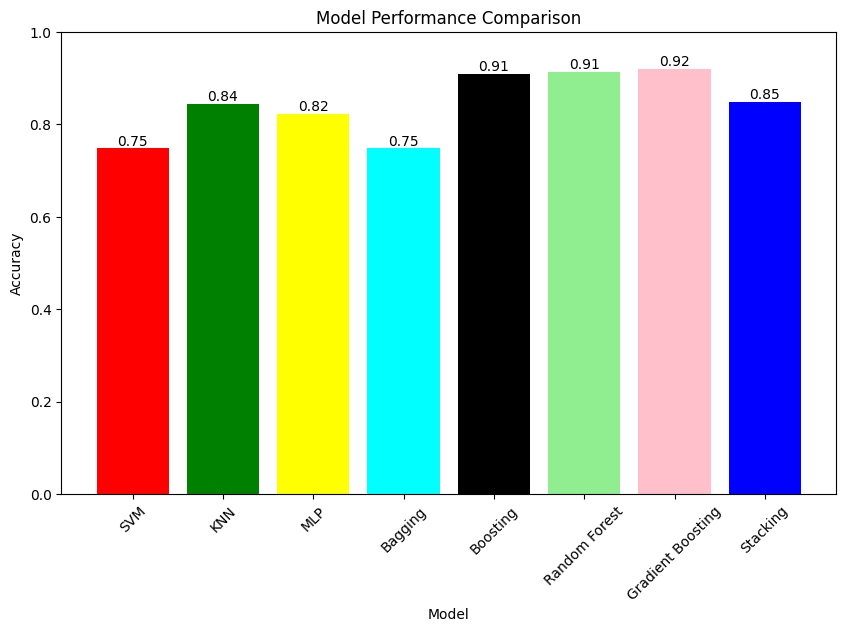

In [14]:
import matplotlib.colors as mcolors

# Define the list of colors
color_list = ['red', 'green', 'yellow', 'cyan', 'black', 'lightgreen', 'pink', 'blue']

plt.figure(figsize=(10, 6))
bars = plt.bar(model_accuracies.keys(), model_accuracies.values(), color=color_list)
plt.ylim(0, 1)
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)

# Add count values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.2f}', ha='center', va='bottom')

plt.show()